In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import cv2
import numpy as np
import torch
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

from captum.attr import (
    LayerAttribution,
    LayerGradCam,
    MultiscaleFastCam
)

from gradcam.utils import visualize_cam

## Run FastCAM with SMOE Scale and Gamma Norm
This notebook's version of fastcam is to combine multiple layers into one object, such that it examplifies the importance of multiscale saliency map

Let's load the image and create the appropriate image tensors
- `raw_img`: image without transformation
- `transformed_img`: image after transform
- `transformed_imgs`: stack two `transform_img` together

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
input_image_name = "./images/ILSVRC2012_val_00049934.224x224.png"
cv_im = cv2.imread(input_image_name)
cv_im = (cv2.cvtColor(cv_im, cv2.COLOR_BGR2RGB) / 255.0).astype(np.float32)
inputs = transform(cv_im)
inputs = inputs.unsqueeze(0)
_, channels, in_height, in_width = inputs.size()

raw_img = torch.tensor(cv_im.transpose(2, 0, 1), requires_grad=True).unsqueeze(0)
transformed_img = inputs
transformed_imgs = torch.cat([inputs, inputs])

Instantiate our ResNet50 PyTorch Module here 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True).to(device).eval()
y_pred = model(transformed_img).argmax()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/ryanchankh/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


We first intialize captum fastcam module by passing in:
- `model`:  our ResNet50 Model
- `layers`: the layers that we want to combine the saliency maps of
- `norm`:   the choice of norm we apply after SMOE Scale

Then by calling `attribute()` returns a tuple of attributions outputed by fastcam
`attributes` has length of 5 and has different shapes based on the size of
the intermediate layers chosen.

Finally, `combine()` is a static method that returns the combined map using the differet
scales of attributions. We can adjust the weight here for different scales. 

In [4]:
fastcam = MultiscaleFastCam(model,
                            layers=[model.relu,
                                    model.layer1[2].relu,
                                    model.layer2[3].relu,
                                    model.layer3[5].relu,
                                    model.layer4[2].relu],
                            norm="gamma")


attributes = fastcam.attribute(transformed_imgs)


combined_map, weighted_maps = fastcam.combine(attributes,
                                              weights=[1.0 for _ in range(5)],
                                              output_shape=(in_height, in_width),
                                              relu_attribution=False)

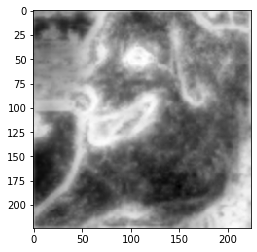

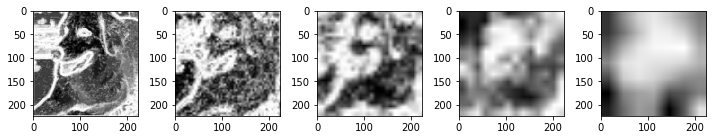

In [5]:
# Plot of the combined saliency maps
csmap = combined_map[0].numpy().transpose(1, 2, 0).squeeze()
plt.imshow(csmap, cmap='gray')
plt.show()
plt.close()

# Plot of Weighted saliency maps
fig, ax = plt.subplots(ncols=5, figsize=(10, 4))
[ax[i].imshow(wmap.numpy(), cmap='gray') for i, wmap in enumerate(weighted_maps[0])]
fig.tight_layout()
plt.show()

## Combine with GradCAM

One advantage of FastCam is that it allows use to combine saliency maps with GradCAM. 

In [6]:
def normalize(x):
    _min, _max = x.min(), x.max()
    return (x - _min).div(_max - _min)

Instantiate a GradCAM attribution module using Captum
GradCAM works usually on the last layer, so we are going 
to pass in `model.layer4`, and get its attributions like 
we did for FastCAM.

In [7]:
gradcam = LayerGradCam(model, model.layer4)
attribute_gradcam = gradcam.attribute(raw_img, 
                                      target=y_pred,
                                      relu_attributions=True)

Then we need to interpolate such that the output shape is the 
same as that of FastCAM, and finally noramlize the attributions 
using for visualization using matplotlib

In [8]:
attribute_gradcam = LayerAttribution.interpolate(attribute_gradcam, 
                                                 (in_height, in_width),
                                                 'bilinear')
attribute_gradcam = normalize(attribute_gradcam)
attribute_gradcam = attribute_gradcam.detach().squeeze().numpy()

In [9]:
# Instantiate a GradCAM attribution module using Captum
# GradCAM works usually on the last layer, so we are going 
# to pass in `model.layer4`, and get its attributions like 
# we did for FastCAM.

Combing FastCAM with GradCAM allows us to create in-class maps
and out-class maps. Then plotting the heatmap using 
`visualize_cam` from gradcam library for consistency

In [10]:
inclass_map = csmap * attribute_gradcam
outclass_map = csmap * (1 - attribute_gradcam)

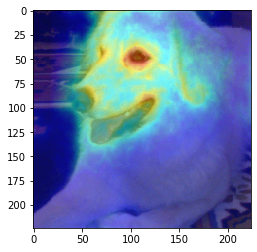

In [11]:
inclass_map = csmap * attribute_gradcam
outclass_map = csmap * (1 - attribute_gradcam)

heatmap, result = visualize_cam(torch.tensor(inclass_map),
                                raw_img,
                                1)
plt.imshow(result.detach().numpy().transpose(1, 2, 0))
plt.show()